# Intro
In this notebook, I implemented two vehicle detectors using SVM with HOG (histogram of gradient) and CNN on gti vehicle dataset (https://www.gti.ssr.upm.es/data/Vehicle_database.html) and data from Udacity. I train the SVM model with HOG feature, and CNN using with the raw image. In the target image, I use sliding window to go through different region of interest and use the model to predict if there's a vehicle within the window. After going through the whole image, a heatmap is generated and thresholded to generate the final bounding boxes of vehicles.

For video, besides generating heatmap for each frame, I applied IIR filter to heatmaps to stablize the result. The bouding boxes are generated based on filtered heatmap. Averaging 5 or 10 frames can also stablize the output but perform worse.   

This notebook uses Scikit-learn for HOG feature and SVM model. It also uses TensorFlow with Keras API for simple CNN model. OpenCV is used for image processing.

# Import modules

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pandas as pd
import cv2
import random
import pickle
import os

from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from moviepy.editor import VideoFileClip

%matplotlib inline  

# Load images
Load images and convert them into YUV color space. (YUV color space generates better result than RGB)

In [19]:
folder_names = ['OwnCollection/vehicles/Far', 
            'OwnCollection/vehicles/Left', 
            'OwnCollection/vehicles/MiddleClose',
            'OwnCollection/vehicles/Right']

car_set = []
for folder_name in folder_names:
    for file in os.listdir(folder_name):
        img = cv2.imread(folder_name + '/' + file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        car_set.append(img)

folder_names = ['OwnCollection/non-vehicles/Far', 
        'OwnCollection/non-vehicles/Left', 
        'OwnCollection/non-vehicles/MiddleClose',
        'OwnCollection/non-vehicles/Right']

no_car_set = []
for folder_name in folder_names:
    for file in os.listdir(folder_name):
        img = cv2.imread(folder_name + '/' + file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        no_car_set.append(img)

# Shuffle data
Build and shuffle training data and labels

In [20]:
data = car_set + no_car_set
label = [True]*len(car_set) + [False]*len(no_car_set)
num_data = len(data)

idxes = list(range(num_data))
random.shuffle(idxes)

x = np.ndarray((num_data, 64, 64, 3))
y = [None]*num_data

counter = 0
for idx in idxes:
    x[counter,:,:,:] = data[idx]/255
    y[counter] = label[idx]
    counter += 1

# HOG and SVM
Train linear SVM with HOG

In [126]:
# Feature vector helper functions
def getHogFeature(img, stackFeatureVector = False):
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2

    features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                      cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                      visualize=True, feature_vector=stackFeatureVector)
    return features

Extract feature vectors and normalize

In [22]:
# Length of feature vector is 5292
x_hog = np.ndarray((num_data, 5292))
for i in range(num_data):
    hogFeatures = np.hstack((getHogFeature(x[i,:,:,0], True), getHogFeature(x[i,:,:,1], True), getHogFeature(x[i,:,:,2], True)))
    x_hog[i, :] = hogFeatures

# Fit standard scaler and apply to the data
x_hog_scaler = StandardScaler().fit(x_hog)
x_hog = x_hog_scaler.transform(x_hog)

Train linear SVM

In [23]:
x_train, x_test, y_train, y_test = train_test_split(x_hog, y, test_size=0.02)
svm_model = LinearSVC()
svm_model.fit(x_train, y_train)
              
print('training acc:', svm_model.score(x_train, y_train))
print('testing acc:', svm_model.score(x_test, y_test))

training acc: 1.0
testing acc: 0.9659863945578231


# CNN
Create data generator for training. Standard normalization.

In [24]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split=0.2)

datagen.fit(x)

train_data = datagen.flow(x, y, batch_size=32, subset='training')
validation_data = datagen.flow(x, y, batch_size=32, subset='validation')

Define CNN model

In [25]:
cnn_model = keras.Sequential()
cnn_model.add(keras.layers.Conv2D(16, kernel_size=(5,5), input_shape=(64, 64, 3), activation='relu'))
cnn_model.add(keras.layers.MaxPool2D(pool_size=(2,2)))
cnn_model.add(keras.layers.Conv2D(16, kernel_size=(5,5), activation='relu'))
cnn_model.add(keras.layers.MaxPool2D(pool_size=(2,2)))
cnn_model.add(keras.layers.Flatten())
cnn_model.add(keras.layers.Dense(units=256,activation='relu'))
cnn_model.add(keras.layers.Dense(units=1,activation='sigmoid'))
cnn_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
cnn_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 60, 16)        1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 16)        6416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 2704)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               692480    
_________________________________________________________________
dens

Train the model with 5 epochs

In [26]:
history = cnn_model.fit_generator(train_data, epochs=5, validation_data=validation_data)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
184/184 [==============================] - 26s 140ms/step - loss: 0.2766 - acc: 0.8904 - val_loss: 0.1233 - val_acc: 0.9584
Epoch 2/5
184/184 [==============================] - 26s 143ms/step - loss: 0.1271 - acc: 0.9503 - val_loss: 0.1088 - val_acc: 0.9625
Epoch 3/5
184/184 [==============================] - 24s 132ms/step - loss: 0.0957 - acc: 0.9681 - val_loss: 0.0966 - val_acc: 0.9625
Epoch 4/5
184/184 [==============================] - 25s 135ms/step - loss: 0.0767 - acc: 0.9712 - val_loss: 0.0573 - val_acc: 0.9788
Epoch 5/5
184/184 [==============================] - 25s 134ms/step - loss: 0.0733 - acc: 0.9747 - val_loss: 0.0735 - val_acc: 0.9720


# Test SVM and CNN models with sample images
## Define helper functions

In [127]:
def findCarSvmForScale(img, ystart, ystop, scale, svm_model, x_scaler):
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    
    # Only search x > 500 
    xstart = 500
    xstop = img.shape[1]
    img_tosearch = img[ystart:ystop, xstart:xstop,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_BGR2YUV)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = getHogFeature(ch1)
    hog2 = getHogFeature(ch2)
    hog3 = getHogFeature(ch3)
    rectangles = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
                
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            test_features = x_scaler.transform(hog_features).reshape(1, -1)

            test_prediction = svm_model.predict(test_features)
            
            if test_prediction[0] == True:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append((xbox_left+xstart, ytop_draw+ystart, win_draw))
                              
    return rectangles

def findCarCnnForWin(img, model, datagen, win_size, step_size):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    h, w, _ = img.shape
    xRange = range(500, w-win_size, step_size)
    yRange = range(400, 500, step_size)
    numWindow = len(xRange)*len(yRange)
    windows = np.ndarray((numWindow, 64, 64, 3))
    xcor = np.ndarray((numWindow, 1))
    ycor = np.ndarray((numWindow, 1))
    counter = 0
    for y in yRange:
        for x in xRange:
            window = img[y:y+win_size, x:x+win_size, :]
            window = cv2.resize(window, (64,64))
            window = window/255
            datagen.standardize(window)
            windows[counter] = window
            xcor[counter] = x
            ycor[counter] = y
            counter += 1
    
    predictP = model.predict(windows)
    rects = [(int(xcor[i]), int(ycor[i]), win_size) for i in range(len(xcor)) if predictP[i] > 0.5]
    return rects

def getHeatMap(img, method, svm_model, x_scaler, cnn_model, datagen, visualize):
    if method == 'svm':
        scales = [1, 1.5, 2, 2.5]
        y_ranges = [(400, 530),(400, 620), (400, 650), (400, 700)]
        num_scale_or_win = len(scales)
    elif method == 'cnn':
        win_sizes = [32, 64, 80, 96, 128]
        step_sizes = [4, 8, 10, 12, 16]
        num_scale_or_win = len(win_sizes)
    else:
        return []
    
    h, w, _ = img.shape
    heat_map = np.zeros((h,w))
    
    if visualize:
        # show original image
        rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure()
        plt.imshow(rgbImg)
        # image for car boxes
        plt.figure()
        plt.imshow(rgbImg)
        ax = plt.gca()
        colors = ['r','g','b','y','c','m','k']
    
    for i in range(num_scale_or_win):
        if method == 'svm':
            # Find cars for specific scale
            scale = scales[i]
            y_range = y_ranges[i]
            rects = findCarSvmForScale(img, y_range[0], y_range[1], scale, svm_model, x_scaler)
        if method == 'cnn':
            # Find cars for specific window size
            win_size = win_sizes[i]
            step_size = step_sizes[i]
            rects = findCarCnnForWin(img, cnn_model, datagen, win_size, step_size)

        for rect in rects:
            x, y, w = rect
            heat_map[y:y+w,x:x+w] += 1
            if visualize:
                # image for car boxes
                re = Rectangle((x,y),w,w,linewidth=2,edgecolor=colors[i],facecolor='none')
                ax.add_patch(re)

    return heat_map

def getBoundingBoxes(heat_map, heat_map_threshold, visualize):
    filtered_heat_map = heat_map > heat_map_threshold
    filtered_heat_map = filtered_heat_map.astype(np.uint8)
    
    if visualize:
        # image for heat map and filtered heat map
        plt.figure()
        plt.subplot(1,2,1)
        plt.imshow(heat_map)
        plt.subplot(1,2,2)
        plt.imshow(filtered_heat_map)

    ccResult = cv2.connectedComponentsWithStats(filtered_heat_map)
    ccStats = ccResult[2]
    
    finalRects = []
    for ccBox in ccStats:
        numPixel = ccBox[4]
        if (numPixel > 20*20) and (numPixel < 500*500):
            finalRects.append(ccBox)

    return finalRects
            
def findCar(img, method, svm_model, x_scaler, cnn_model, datagen, visualize):
    if method == 'svm':
        heat_map_threshold = 10
    elif method == 'cnn':
        heat_map_threshold = 50
    else:
        return []
    
    heat_map = getHeatMap(img, method, svm_model, x_scaler, cnn_model, datagen, visualize)
    finalRects = getBoundingBoxes(heat_map, heat_map_threshold, visualize)

    if visualize:
        rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure()
        plt.imshow(rgbImg)
        ax = plt.gca()
        for rect in finalRects:
            x, y, w, h, _ = rect
            rect = Rectangle((x,y),w,h,linewidth=2,edgecolor='y',facecolor='none')
            ax.add_patch(rect)
        plt.axis('off')
                    
    return finalRects

## SVM results

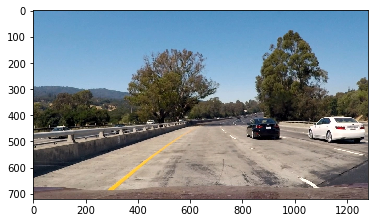

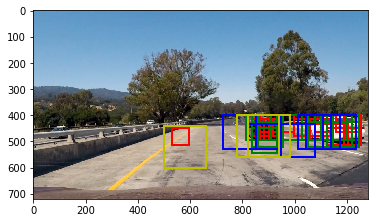

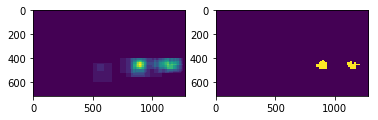

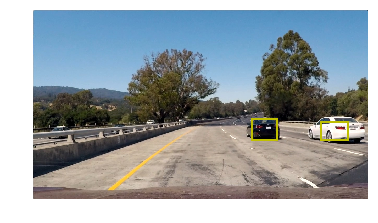

In [128]:
rects = findCar(cv2.imread('test1.jpg'), 'svm', svm_model, x_hog_scaler, cnn_model, datagen, True)

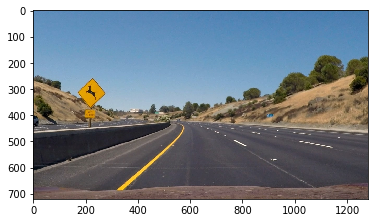

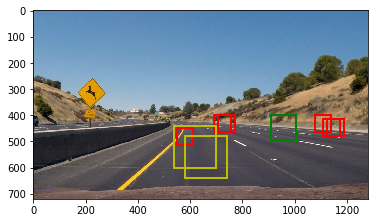

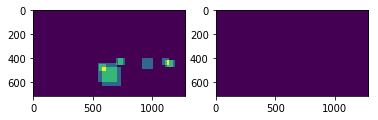

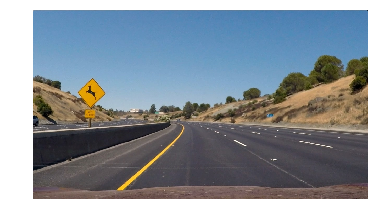

In [129]:
rects = findCar(cv2.imread('test2.jpg'), 'svm', svm_model, x_hog_scaler, cnn_model, datagen, True)

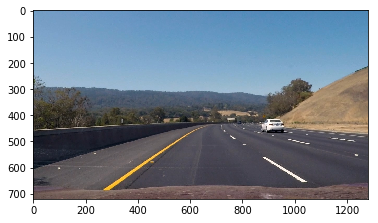

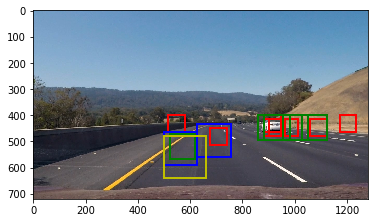

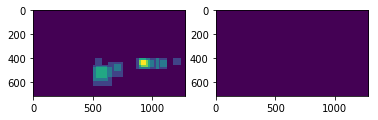

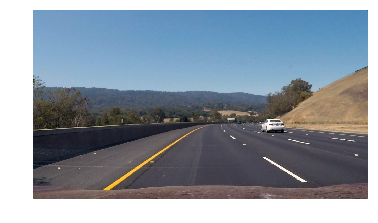

In [130]:
rects = findCar(cv2.imread('test3.jpg'), 'svm', svm_model, x_hog_scaler, cnn_model, datagen, True)

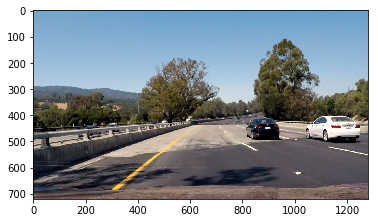

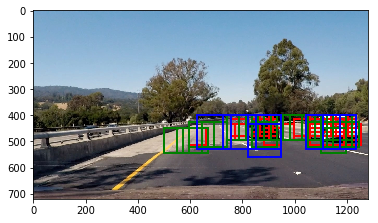

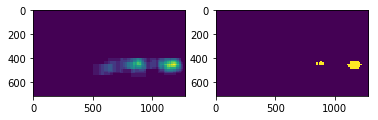

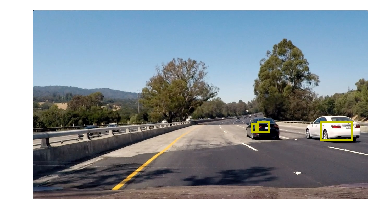

In [131]:
rects = findCar(cv2.imread('test4.jpg'), 'svm', svm_model, x_hog_scaler, cnn_model, datagen, True)

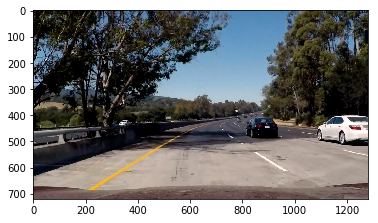

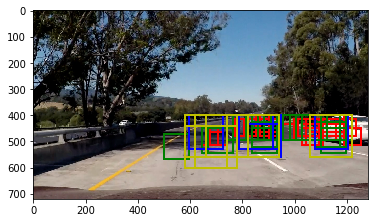

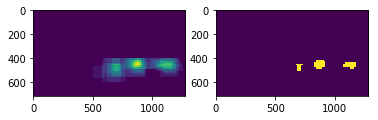

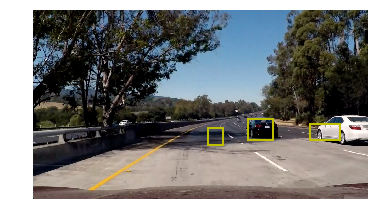

In [132]:
rects = findCar(cv2.imread('test5.jpg'), 'svm', svm_model, x_hog_scaler, cnn_model, datagen, True)

## CNN results

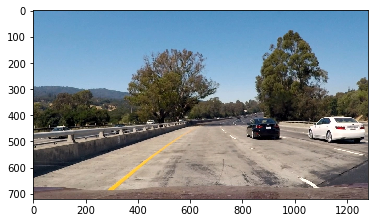

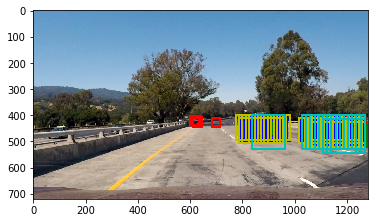

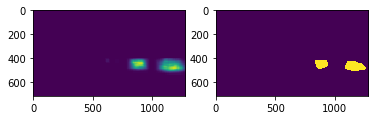

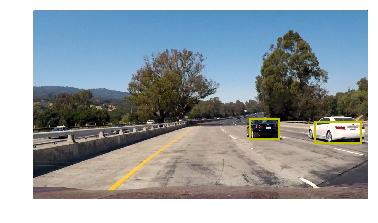

In [133]:
rects = findCar(cv2.imread('test1.jpg'), 'cnn', svm_model, x_hog_scaler, cnn_model, datagen, True)

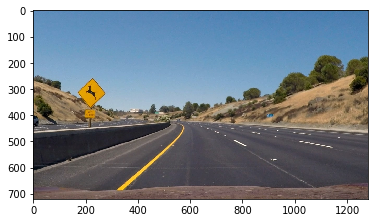

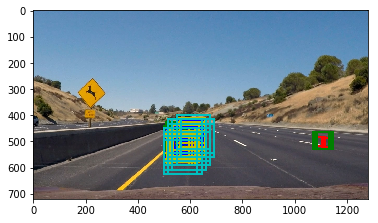

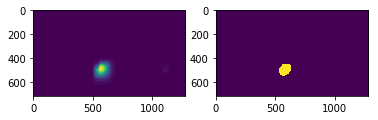

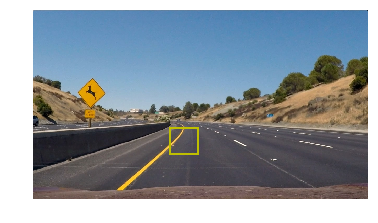

In [134]:
rects = findCar(cv2.imread('test2.jpg'), 'cnn', svm_model, x_hog_scaler, cnn_model, datagen, True)

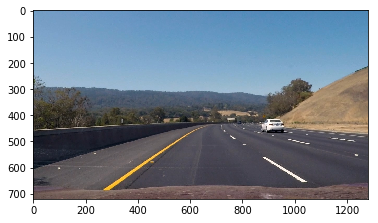

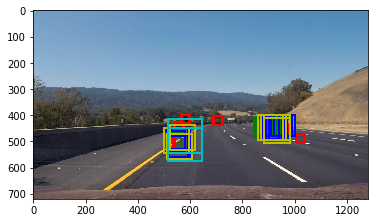

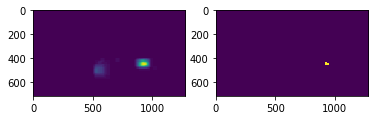

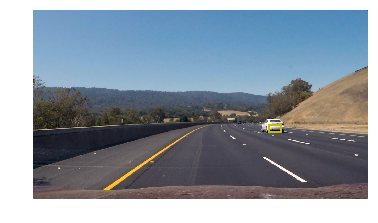

In [135]:
rects = findCar(cv2.imread('test3.jpg'), 'cnn', svm_model, x_hog_scaler, cnn_model, datagen, True)

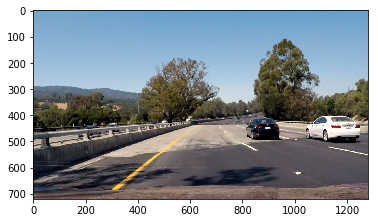

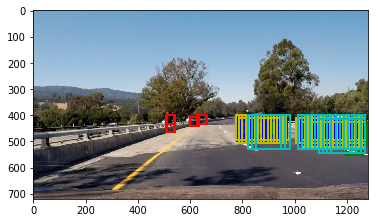

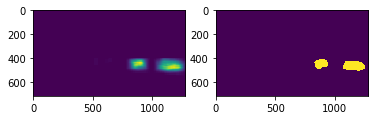

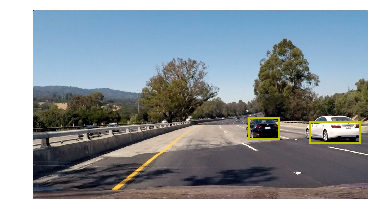

In [136]:
rects = findCar(cv2.imread('test4.jpg'), 'cnn', svm_model, x_hog_scaler, cnn_model, datagen, True)

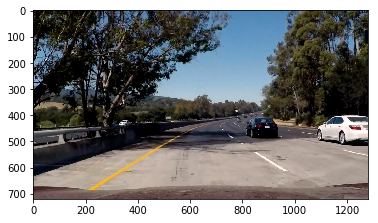

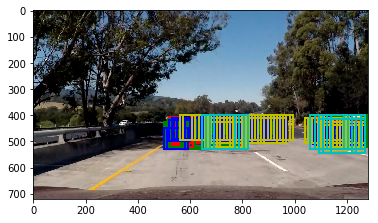

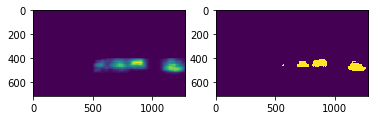

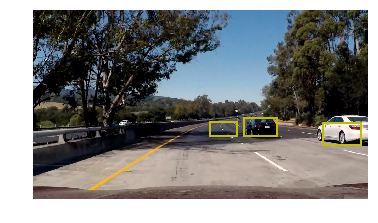

In [137]:
rects = findCar(cv2.imread('test5.jpg'), 'cnn', svm_model, x_hog_scaler, cnn_model, datagen, True)

# Test Videos
## Define helper functions

In [147]:
def movingAvgFilter(prevImgs, curImg, threshold):
    combinedImg = curImg.copy()
    for img in prevImgs:
        combinedImg += img
    rects = getBoundingBoxes(combinedImg, threshold, False)
    return rects
    
def process_image_svm_movingAvg(img):    
    heat_map = getHeatMap(img, 'svm', svm_model, x_hog_scaler, cnn_model, datagen, False)
    heat_map[heat_map < 9] = 0
    
    if process_image_svm_movingAvg.framCnt > process_image_svm_movingAvg.num_prev_frame:
        rects = movingAvgFilter(process_image_svm_movingAvg.prevImgs, heat_map, 100)
        for rect in rects:
            x, y, w, h, _ = rect
            cv2.rectangle(img, (x,y), (x+w,y+h), (0,0,255), 6)    

    for i in range(1, process_image_svm_movingAvg.num_prev_frame):
        process_image_svm_movingAvg.prevImgs[i-1] = process_image_svm_movingAvg.prevImgs[i]
    process_image_svm_movingAvg.prevImgs[-1] = heat_map
    process_image_svm_movingAvg.framCnt += 1

    return img

# function variables to keep states
process_image_svm_movingAvg.framCnt = 1
process_image_svm_movingAvg.num_prev_frame = 14
process_image_svm_movingAvg.prevImgs = [None]*process_image_svm_movingAvg.num_prev_frame

def process_image_svm_iir(img):    
    heat_map = getHeatMap(img, 'svm', svm_model, x_hog_scaler, cnn_model, datagen, False)
    heat_map[heat_map < 9] = 0
    
    if process_image_svm_iir.firstFrame:
        process_image_svm_iir.prevImg = heat_map
        process_image_svm_iir.firstFrame = False
    else:
        combinedImg = 0.1*heat_map + 0.9*process_image_svm_iir.prevImg
        rects = getBoundingBoxes(combinedImg, 9, False)
        for rect in rects:
            x, y, w, h, _ = rect
            cv2.rectangle(img, (x,y), (x+w,y+h), (0,0,255), 6)    
        process_image_svm_iir.prevImg = combinedImg
        
    return img

# function variables to keep states
process_image_svm_iir.prevImg = None
process_image_svm_iir.firstFrame = True


def process_image_cnn(img):    
    heat_map = getHeatMap(img, 'cnn', svm_model, x_hog_scaler, cnn_model, datagen, False)
    heat_map[heat_map < 50] = 0

    if process_image_cnn.firstFrame:
        process_image_cnn.prevImg = heat_map
        process_image_cnn.firstFrame = False
    else:
        combinedImg = 0.1*heat_map + 0.9*process_image_cnn.prevImg
        rects = getBoundingBoxes(combinedImg, 9, False)
        for rect in rects:
            x, y, w, h, _ = rect
            cv2.rectangle(img, (x,y), (x+w,y+h), (0,0,255), 6)    
        process_image_cnn.prevImg = combinedImg
    
    return img

# function variables to keep states
process_image_cnn.prevImg = None
process_image_cnn.firstFrame = True


## Generate SVM videos

In [148]:
project_video_path = 'test_video.mp4'
project_video_svm_output = 'test_video_svm_avg.mp4'

project_video = VideoFileClip(project_video_path)
white_clip = project_video.fl_image(process_image_svm_movingAvg)
%time white_clip.write_videofile(project_video_svm_output, audio=False)


                                                            


                                                                        



                                               

                                                                  
t:   8%|▊         | 3/38 [117:50:12<01:05,  1.86s/it, now=None]


t:   8%|▊         | 3/38 [117:51:57<01:15,  2.15s/it, now=None]now=None]



t:  18%|█▊        | 7/38 [00:30<01:23,  2.69s/it, now=None]

t:   3%|▎         | 1/38 [116:47:04<4321:01:40, 420424.35s/it, now=None]
                                                            


                                                                        



                                               

                                                                  
t:   8%|▊         | 3/38 [117:50:12<01:05,  1.86s/it, now=None]


t:   8%|▊         | 3/38 [117:51:57<01:15,  2.15s/it, now=None]now=None]



t:  18%|█▊        | 7/38 [00:30<01:23,  2.69s/it, now=None]

t:   3%|▎ 

Moviepy - Building video test_video_svm_avg.mp4.
Moviepy - Writing video test_video_svm_avg.mp4








t:   5%|▌         | 2/38 [00:02<00:51,  1.44s/it, now=None]




t:   8%|▊         | 3/38 [00:06<01:10,  2.02s/it, now=None]




t:  11%|█         | 4/38 [00:09<01:23,  2.46s/it, now=None]




t:  13%|█▎        | 5/38 [00:12<01:27,  2.66s/it, now=None]




t:  16%|█▌        | 6/38 [00:16<01:30,  2.81s/it, now=None]




t:  18%|█▊        | 7/38 [00:19<01:30,  2.92s/it, now=None]




t:  21%|██        | 8/38 [00:22<01:26,  2.90s/it, now=None]




t:  24%|██▎       | 9/38 [00:25<01:25,  2.94s/it, now=None]




t:  26%|██▋       | 10/38 [00:28<01:27,  3.12s/it, now=None]




t:  29%|██▉       | 11/38 [00:31<01:25,  3.17s/it, now=None]




t:  32%|███▏      | 12/38 [00:35<01:22,  3.19s/it, now=None]




t:  34%|███▍      | 13/38 [00:38<01:17,  3.11s/it, now=None]




t:  37%|███▋      | 14/38 [00:41<01:16,  3.17s/it, now=None]




t:  39%|███▉      | 15/38 [00:44<01:13,  3.18s/it, now=None]




t:  42%|████▏     | 16/38 [00:47<01:08,  3.11s/it, now=None]




t:  45%|████▍     | 17/38 [0

Moviepy - Done !
Moviepy - video ready test_video_svm_avg.mp4
CPU times: user 1min 57s, sys: 1.27 s, total: 1min 58s
Wall time: 1min 59s


In [140]:
project_video_path = 'test_video.mp4'
project_video_svm_output = 'test_video_svm_iir.mp4'

project_video = VideoFileClip(project_video_path)
white_clip = project_video.fl_image(process_image_svm_iir)
%time white_clip.write_videofile(project_video_svm_output, audio=False)


                                                           


                                                                       

                                                                 
t:   8%|▊         | 3/38 [116:45:05<01:05,  1.86s/it, now=None]


t:   8%|▊         | 3/38 [116:46:50<01:15,  2.15s/it, now=None]now=None]

t:   3%|▎         | 1/38 [115:41:57<4280:52:13, 416517.13s/it, now=None]
                                                            


                                                                        

                                                                  
t:   8%|▊         | 3/38 [116:45:05<01:05,  1.86s/it, now=None]


t:   8%|▊         | 3/38 [116:46:50<01:15,  2.15s/it, now=None]now=None]

t:   3%|▎         | 1/38 [115:41:57<4280:52:14, 416517.15s/it, now=None]



t:   0%|          | 0/38 [00:00<?, ?it/s, now=None]

Moviepy - Building video test_video_svm_iir.mp4.
Moviepy - Writing video test_video_svm_iir.mp4







t:   5%|▌         | 2/38 [00:03<00:54,  1.53s/it, now=None]



t:   8%|▊         | 3/38 [00:06<01:08,  1.97s/it, now=None]



t:  11%|█         | 4/38 [00:09<01:19,  2.34s/it, now=None]



t:  13%|█▎        | 5/38 [00:12<01:29,  2.71s/it, now=None]



t:  16%|█▌        | 6/38 [00:15<01:30,  2.81s/it, now=None]



t:  18%|█▊        | 7/38 [00:19<01:32,  3.00s/it, now=None]



t:  21%|██        | 8/38 [00:22<01:31,  3.05s/it, now=None]



t:  24%|██▎       | 9/38 [00:25<01:28,  3.05s/it, now=None]



t:  26%|██▋       | 10/38 [00:28<01:28,  3.15s/it, now=None]



t:  29%|██▉       | 11/38 [00:32<01:31,  3.40s/it, now=None]



t:  32%|███▏      | 12/38 [00:36<01:28,  3.40s/it, now=None]



t:  34%|███▍      | 13/38 [00:39<01:24,  3.40s/it, now=None]



t:  37%|███▋      | 14/38 [00:42<01:19,  3.29s/it, now=None]



t:  39%|███▉      | 15/38 [00:45<01:13,  3.22s/it, now=None]



t:  42%|████▏     | 16/38 [00:48<01:09,  3.17s/it, now=None]



t:  45%|████▍     | 17/38 [00:51<01:05,  3.1

Moviepy - Done !
Moviepy - video ready test_video_svm_iir.mp4
CPU times: user 1min 57s, sys: 1.52 s, total: 1min 59s
Wall time: 2min


## Generate CNN video

In [143]:
project_video_path = 'test_video.mp4'
project_video_cnn_output = 'test_video_cnn.mp4'

project_video = VideoFileClip(project_video_path)
white_clip = project_video.fl_image(process_image_cnn)
%time white_clip.write_videofile(project_video_cnn_output, audio=False)


                                                            


                                                                        

                                                                  
t:   8%|▊         | 3/38 [116:50:12<01:05,  1.86s/it, now=None]


t:   8%|▊         | 3/38 [116:51:57<01:15,  2.15s/it, now=None]now=None]

t:   3%|▎         | 1/38 [115:47:04<4284:01:56, 416824.78s/it, now=None]
                                                            


                                                                        

                                                                  
t:   8%|▊         | 3/38 [116:50:12<01:05,  1.86s/it, now=None]


t:   8%|▊         | 3/38 [116:51:57<01:15,  2.15s/it, now=None]now=None]

t:   3%|▎         | 1/38 [115:47:04<4284:01:57, 416824.79s/it, now=None]



t:   0%|          | 0/38 [00:00<?, ?it/s, now=None]

Moviepy - Building video test_video_cnn.mp4.
Moviepy - Writing video test_video_cnn.mp4







t:   5%|▌         | 2/38 [00:13<04:04,  6.78s/it, now=None]



t:   8%|▊         | 3/38 [00:27<05:09,  8.83s/it, now=None]



t:  11%|█         | 4/38 [00:40<05:47, 10.22s/it, now=None]



t:  13%|█▎        | 5/38 [00:54<06:09, 11.20s/it, now=None]



t:  16%|█▌        | 6/38 [01:07<06:21, 11.92s/it, now=None]



t:  18%|█▊        | 7/38 [01:21<06:25, 12.43s/it, now=None]



t:  21%|██        | 8/38 [01:34<06:22, 12.76s/it, now=None]



t:  24%|██▎       | 9/38 [01:48<06:16, 12.98s/it, now=None]



t:  26%|██▋       | 10/38 [02:01<06:07, 13.13s/it, now=None]



t:  29%|██▉       | 11/38 [02:15<05:57, 13.23s/it, now=None]



t:  32%|███▏      | 12/38 [02:28<05:46, 13.33s/it, now=None]



t:  34%|███▍      | 13/38 [02:42<05:35, 13.43s/it, now=None]



t:  37%|███▋      | 14/38 [02:56<05:22, 13.45s/it, now=None]



t:  39%|███▉      | 15/38 [03:09<05:09, 13.47s/it, now=None]



t:  42%|████▏     | 16/38 [03:23<04:56, 13.47s/it, now=None]



t:  45%|████▍     | 17/38 [03:36<04:43, 13.4

Moviepy - Done !
Moviepy - video ready test_video_cnn.mp4
CPU times: user 25min 28s, sys: 17min 18s, total: 42min 46s
Wall time: 8min 35s
